In [1]:
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_roc, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import sys
import io

In [2]:
warnings.filterwarnings(action = "ignore")

# 1. Introduction

**This report seeks to:**

1) Analyze Churn phenomenon on data coming from Telco Sector.  
2) Propose the best Target for a Retention Commercial Campaign.

Data Source: *Kaggle*  https://www.kaggle.com/blastchar/telco-customer-churn  
<< Each row represents a customer, and each column contains customer’s attributes. The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is our target. >>



# 2. Background
Customer retention refers to the activities and actions companies and organizations take to reduce the number of customer defections. The goal of customer retention campaigns is to help companies retain as many customers as possible.

In the case of Telco Sector, we try to first identify these customers with potential churn behaviors by:  
1) Their attributes such as gender and age  
2) Their service status which includes phone service and internet service  
3) Payment and billing methods as well as monthly and total charges

Then, we rate these customers by score model and order them by the probability of churning, so that customers who are more likely to churn are contacted in a higher priority.  
Meanwhile, we also need to take into consideration the cost of overall contacts to balance the budget.

Finally, we propose a retention plan which includes target size and cut-off selection.

<br />

**This report is mainly composed of:**

I. Data Preprocessing  
II. Exploratory Data Analysis  
III. Three Logistic Models:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) benchmark logistic (with all original variables, for interpretation purpose)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) logistic with variable transformations  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3) logistic with variable transformations and selections  
IV. Comparisons of the Three Models in Terms of Performance  
V. Application of the Best Model in Customer Retention  

# 3. Objective

**Maximizing Retention under Break-even Balance Constraint:** Identify the Target size (in terms of number of customers) to contact through the Retention Commercial Campaign in order to have a Break-even Balance: costs for contacts have to be compensated by revenues obtained by retained customers.


# 4. Framework

### 4.1 Assumption

*  Cost for each single contact: 5 euros
*  Expected Revenues for each retained customer: 25 euros
*  Expected Retention rate obtained through the Commercial Campaign: 25%

### 4.2 Target
Maximizing retention.

### 4.3 Constraint

Costs for contacts have to be compensated by revenues obtained by
retained customers.

### 4.4 Analysis
Define Positive for customers who will churn, Negative for customers who will not churn. 

* True Positive Rate(TPr): percentage of customers who will churn and are predicted so.
* True Negative Rate(TNr): percentage of customers who will not churn and are predicted not so.
* False Positive Rate(FPr): percentage of customers who will not churn but are predicted so.
* False Negative Rate(FNr): percentage of customers who will churn but are predicted not so.

The optimization problems boils down to be:  
Max True Positive Cases, that is, the number of customers who will churn and are contacted, under the constraint: $\{ 25 * TPr * churn\_rate * 25\% - 5 * [ (TPr * churn\_rate + FPr * (1 - churn\_rate ) ] \} >= 0$.

Under the assumption that the constraint is satisfied, clearly the more customers we contact, the better. Therefore, here we need to choose the most lenient cutoff of the score model, such that the constraint is satisfied.

### 4.5 Method

1. Through variable selection and / or transformation, we fit a logistic regression model.
2. Select a cut-off score of the predicted churn probability, such that customer retention is maximized under the constraint.

# 5. Exploratory Data Analysis

### 5.1 Variable Codification Problem

The data has one problem. If the value of PhoneService is "No", then surely the value of MultipleLines will be "No phone service", and vice versa. Same thing holds for InternetService with OnlineSecurity, OnlineBackup, Device Protection, Techsupport, StreamingTV and StreamingMovies. In short, there exists multicollinearity. A tentative solution is to preserve PhoneService and InternetService while setting "No phone service" and "No internet access" to "No".

In [3]:
raw_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
raw_data.set_index("customerID", inplace = True)

In [5]:
raw_data.shape

(7043, 20)

### 5.2 Missing Data

**There seems to be no missing data at first glance. However, we observe that TotalCharges, which is supposed to be a variable that takes float values, now takes string values.**

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


**The number of missing data is very small, so we just drop it.**

In [7]:
(raw_data["TotalCharges"] == " ").sum()

11

In [8]:
cleaned_data = raw_data[raw_data["TotalCharges"] != " "]
cleaned_data["TotalCharges"] = cleaned_data["TotalCharges"].astype(float)

**Now we only need to check other string values. We see that there is no missing data among them.**

In [9]:
cleaned_data[ ["OnlineSecurity", 
               "OnlineBackup", 
               "DeviceProtection", 
               "TechSupport", 
               "StreamingTV", 
               "StreamingMovies" ] ].apply(lambda x: x.value_counts())

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
No,3497,3087,3094,3472,2809,2781
Yes,2015,2425,2418,2040,2703,2731
No internet service,1520,1520,1520,1520,1520,1520


In [10]:
cleaned_data[ ["Partner", 
               "Dependents", 
               "PhoneService",  
               "PaperlessBilling", 
               "Churn"] ].apply(lambda x: x.value_counts())

,Partner,Dependents,PhoneService,PaperlessBilling,Churn
No,3639,4933,680,2864,5163
Yes,3393,2099,6352,4168,1869


In [11]:
for column in ["MultipleLines", "gender", "InternetService", "Contract", "PaymentMethod"]:
    print(cleaned_data[column].value_counts(), '\n')

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64 

Male      3549
Female    3483
Name: gender, dtype: int64 

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64 

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64 

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64 



### 5.3 Encoding Variable

In [12]:
reg_data = cleaned_data.copy()
for column in ["Partner",
               "Dependents", 
               "PhoneService", 
               "MultipleLines", 
               "OnlineSecurity", 
               "OnlineBackup", 
               "DeviceProtection", 
               "TechSupport", 
               "StreamingTV", 
               "StreamingMovies", 
               "PaperlessBilling", 
               "Churn"]:
    reg_data[column] = reg_data[column].apply(lambda x: 0 if x == "No" else x)
    reg_data[column] = reg_data[column].apply(lambda x: 1 if x == "Yes" else x)
reg_data["gender"] = reg_data["gender"].apply(lambda x: 0 if x == "Female" else 1)

for column in ["MultipleLines", 
               "OnlineSecurity", 
               "OnlineBackup", 
               "DeviceProtection", 
               "TechSupport", 
               "StreamingTV", 
               "StreamingMovies"]:
    reg_data[column] = reg_data[column].apply(lambda x: 0 if x not in [0, 1] else x)

### 5.4 Outliers and Transformations (univariate analysis & data visualisation)

**Under the criteria of 1.5 IQR, there are no outliers.**

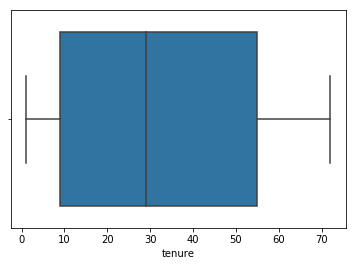

In [13]:
ax = sns.boxplot(reg_data["tenure"], whis = 1.5)

**Under the criteria of 1.5 IQR, there are no outliers.**

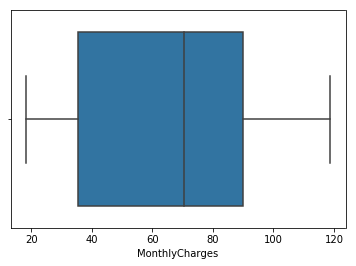

In [14]:
ax = sns.boxplot(reg_data["MonthlyCharges"], whis = 1.5)

**Under the criteria of 1.5 IQR, there are no outliers.**

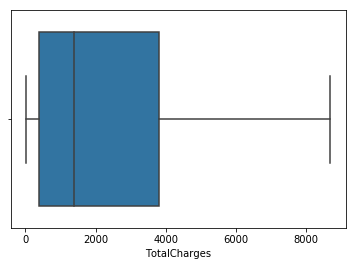

In [15]:
ax = sns.boxplot(reg_data["TotalCharges"], whis = 1.5)

**Looks good.**

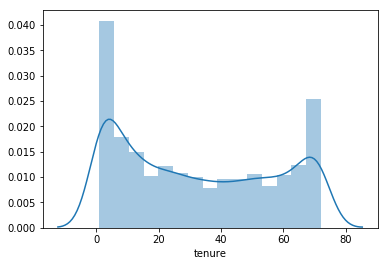

In [16]:
ax = sns.distplot(reg_data["tenure"])

**Not bad.**

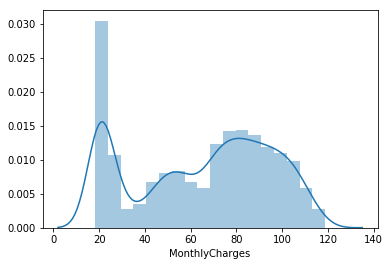

In [17]:
ax = sns.distplot(reg_data["MonthlyCharges"])

**"TotalCharges" is highly right skewed. We propbably need to apply transformation on it.**

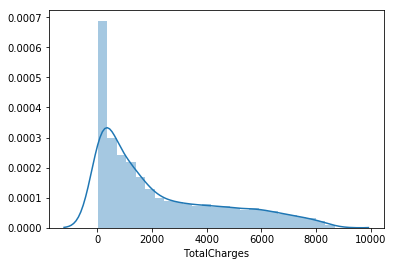

In [18]:
ax = sns.distplot(reg_data["TotalCharges"])

**We apply cubic-root transformation here because the result looks more balanced.**

In [19]:
reg_data["cbrt_TotalCharges"] = np.cbrt(reg_data["TotalCharges"].values)
reg_data.drop(["TotalCharges"], axis = 1, inplace = True)

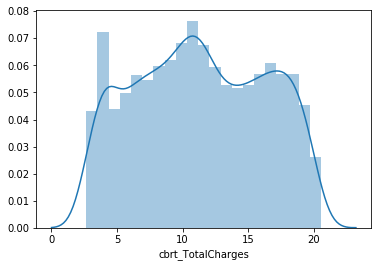

In [20]:
ax = sns.distplot(reg_data["cbrt_TotalCharges"])

### 5.5 Underlying Multicollinearity

**Over 90% of customers order phone service, which indicates its high correlation with constant.**

In [21]:
reg_data.apply(["mean"]).round(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,cbrt_TotalCharges
mean,0.5,0.16,0.48,0.3,32.42,0.9,0.42,0.29,0.34,0.34,0.29,0.38,0.39,0.59,64.8,0.27,11.36


**We can see that there exists multicollinearity problems. The darker the color, the more severe the problem.  (excluding the diagnostic values of course)**

Text(0.5, 1.0, 'Correlation Matrix')

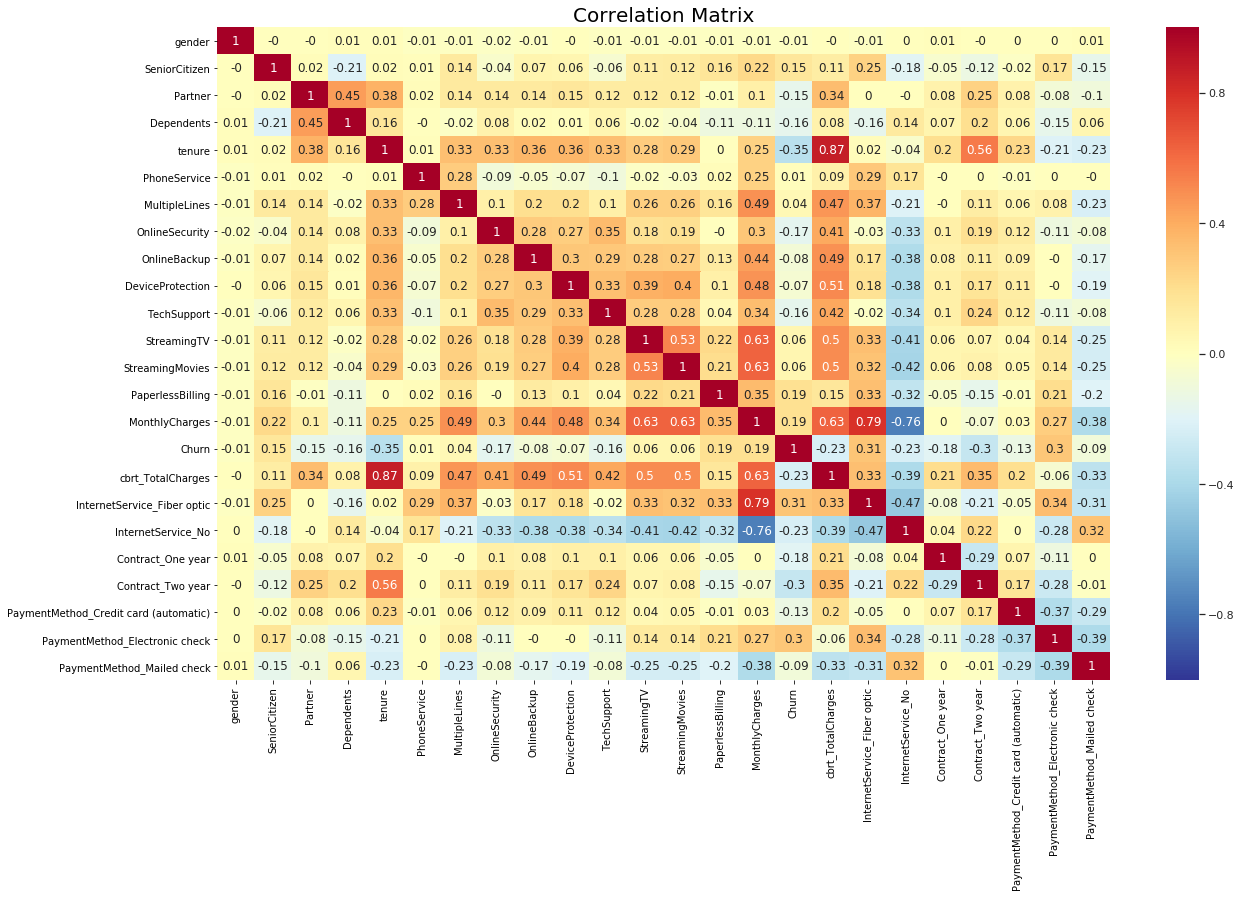

In [22]:
cor_matrix = pd.get_dummies(reg_data, drop_first = True).corr()
plt.figure(figsize = (20, 12))
ax = plt.axes()
sns.set(font_scale = 1)
sns.heatmap(cor_matrix.round(2), cmap = "RdYlBu_r", vmin = -1, vmax = 1, annot = True)
ax.set_title("Correlation Matrix", {'fontsize': 20})

* "tenure" are strongly correlated with "cbrt_TotalCharges", because the longer a customer stays with the company, the more she/he is likely to spend.

* Internet service and monthly charges are strongly correlated, probably because the internet service fee is high.

P.S. There are still variables that are mildly correlated and variables group (>2) can also create multicollinearity.

In [23]:
cor_df = pd.DataFrame(dict(var1 = [], var2 = [], cor = []))

index = np.where( (cor_matrix > .75).values | (cor_matrix < -.75).values )
subindex = np.where(index[0] - index[1] != 0)[0]

for count, i in enumerate(subindex):
    if count < len(subindex):
        matrix_index1 = index[0][i]
        matrix_index2 = index[1][i]
        cor_df = cor_df.append({"var1" :cor_matrix.columns[matrix_index1],
                                "var2": cor_matrix.columns[matrix_index2],
                                "cor": cor_matrix.iloc[matrix_index1, matrix_index2]},
                               ignore_index = True)
        
cor_df = cor_df.sort_values(["cor"], ascending = False).reset_index(drop = True)
cor_df.apply(lambda x: set( [x["var1"], x["var2"]] ), axis = 1) \
      .to_frame() \
      .join(cor_df["cor"])[::2] \
      .rename({0: "variable"}, axis = 1) \
      .reset_index(drop = True) \
      .round(2)

,variable,cor
0,"{tenure, cbrt_TotalCharges}",0.87
1,"{InternetService_Fiber optic, MonthlyCharges}",0.79
2,"{InternetService_No, MonthlyCharges}",-0.76


**Since high correlations exist among some variables, We need variable selections to solve multicollinearity.**

### 5.6 Summary Statistics of All Variables 

* **continous variables**

In [24]:
numeric_summary1 = reg_data[ ["tenure", "MonthlyCharges", "cbrt_TotalCharges"] ].describe()
numeric_summary2 = reg_data[ ["tenure", "MonthlyCharges", "cbrt_TotalCharges"] ].groupby([1] * reg_data.shape[0]).agg([ stats.iqr, np.var, stats.skew, stats.kurtosis ]).stack()
numeric_summary2.index = numeric_summary2.index.droplevel()
numeric_summary1.append(numeric_summary2).round(2)

,tenure,MonthlyCharges,cbrt_TotalCharges
count,7032.00,7032.00,7032.00
mean,32.42,64.80,11.36
std,24.55,30.09,4.90
min,1.00,18.25,2.66
25%,9.00,35.59,7.38
50%,29.00,70.35,11.18
75%,55.00,89.86,15.60
max,72.00,118.75,20.56
iqr,46.00,54.27,8.22
var,602.47,905.17,24.00


* **proportion statistics of categorical variables**

In [25]:
categorical_index = reg_data.columns.difference(["tenure", "MonthlyCharges", "cbrt_TotalCharges"] )
reg_data[ categorical_index ].apply(lambda x: (x.value_counts()/ x.count())).round(2).fillna(" ")

,Churn,Contract,Dependents,DeviceProtection,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,gender
0,0.73,,0.7,0.66,,0.58,0.66,0.71,0.41,0.52,,0.1,0.84,0.61,0.62,0.71,0.5
1,0.27,,0.3,0.34,,0.42,0.34,0.29,0.59,0.48,,0.9,0.16,0.39,0.38,0.29,0.5
Month-to-month,,0.55,,,,,,,,,,,,,,,
Two year,,0.24,,,,,,,,,,,,,,,
One year,,0.21,,,,,,,,,,,,,,,
Fiber optic,,,,,0.44,,,,,,,,,,,,
DSL,,,,,0.34,,,,,,,,,,,,
No,,,,,0.22,,,,,,,,,,,,
Electronic check,,,,,,,,,,,0.34,,,,,,
Mailed check,,,,,,,,,,,0.23,,,,,,


### 5.7 Let the Data Speak! (bivariate analysis & data visualisation)

**Longer contracts lead to lower churns.**  
**Senior citizens are more likely to churn.**

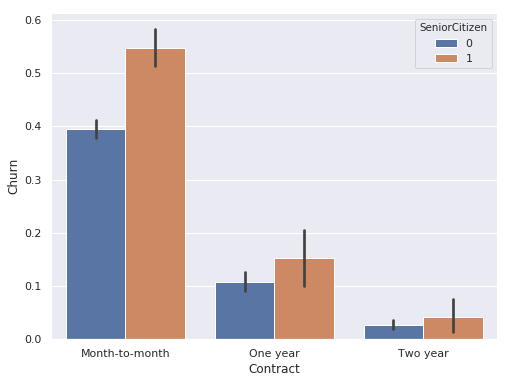

In [26]:
plt.figure(figsize = (8, 6))
sns.barplot(x = "Contract", y = "Churn", hue = "SeniorCitizen", data = reg_data)

**Conditional on tenure, the larger the total charges, the more likely for a customer to churn. (Demand Theory)**  
**The longer the tenure, the scarcer the orange points, the less likely for a customer to churn. (Loyalty)** 

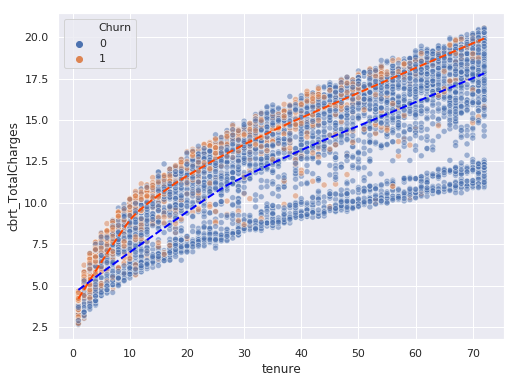

In [27]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = "tenure", y = "cbrt_TotalCharges", hue = "Churn", alpha = .5, data = reg_data)
sns.regplot(x = "tenure", y = "cbrt_TotalCharges", data = reg_data.query("Churn == 1"), scatter = False, lowess = True, line_kws = {"linewidth": 2, "linestyle": "--"}, color = "orangered")
sns.regplot(x = "tenure", y = "cbrt_TotalCharges", data = reg_data.query("Churn == 0"), scatter = False, lowess = True, line_kws = {"linewidth": 2, "linestyle": "--"}, color = "blue")

**Customers who churn have higher MonthlyCharges. (Demand Theory)**`  
**Gender seems to have no effect on MonthlyCharges. (Almost Symmetric)**

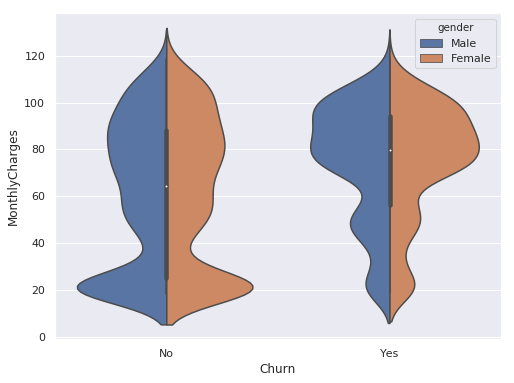

In [28]:
plt.figure(figsize = (8, 6))
sns.violinplot(x = "Churn", y = "MonthlyCharges", hue = "gender", hue_order = ["Male", "Female"], split = True, data = cleaned_data)

In [29]:
reg_data.insert(reg_data.shape[1] - 2, "TotalCharges",  reg_data["cbrt_TotalCharges"].values ** 3)

**Though we assume all customers generate the same revenue, it is not true in reality:**

* The scatter plot tells us that it is not wise to retain every customer but customers whose monthly charges are high, since the difference of total charges accumulates.  
* The histogram tells us that while most customers generate mild revenue, few customers generate huge revenue. We should focus on these minorities, who are called Most Valuable Customers.

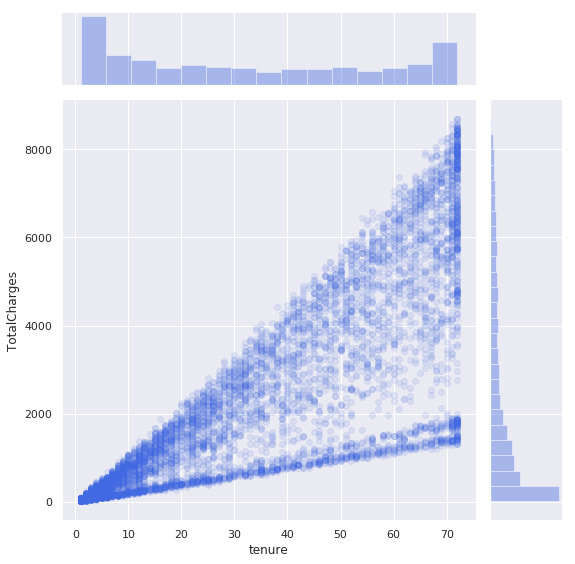

In [30]:
sns.jointplot(x = "tenure", y = "TotalCharges", data = reg_data, alpha = .1, height = 8, color = "royalblue")

## 6. PCA and Cluster

**The results of PCA and cluster with Euclidean Distance on categorical variables are far from satisfactory and hard to interpret, so they are not present here.**

## 7. Benchmark Logistic Regression
**In this part, we focus less on prediction but more on interpretation.**

### 7.1 Assumptions Checking

1. Binary logistic regression requires the dependent variable to be binary.  
   Check.
   
2. Logistic regression requires the observations to be independent of each other.  
   There is no information on how this sample is acquired. Nevertheless, we need to assume this to continue our journey.

3. Logistic regression requires there to be little or no multicollinearity among the independent variables.  
   This assumption is actually violated. Later, we will perform variable selections to solve this problem, but then the result will be more difficult to interpret.

4. Logistic regression assumes linearity of independent variables and log odds.  
   This is an assumption that we cannot check.

5. Logistic regression typically requires a large sample size. A general guideline is that a minimum of 10 observations is needed with the least frequent outcome for each independent variable in the model.  
   10 * 19 / 0.266 = 714 < 7032. So, we have enough observations.

### 7.2 Model Fitting

In [31]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
gender               7032 non-null int64
SeniorCitizen        7032 non-null int64
Partner              7032 non-null int64
Dependents           7032 non-null int64
tenure               7032 non-null int64
PhoneService         7032 non-null int64
MultipleLines        7032 non-null int64
InternetService      7032 non-null object
OnlineSecurity       7032 non-null int64
OnlineBackup         7032 non-null int64
DeviceProtection     7032 non-null int64
TechSupport          7032 non-null int64
StreamingTV          7032 non-null int64
StreamingMovies      7032 non-null int64
Contract             7032 non-null object
PaperlessBilling     7032 non-null int64
PaymentMethod        7032 non-null object
MonthlyCharges       7032 non-null float64
TotalCharges         7032 non-null float64
Churn                7032 non-null int64
cbrt_TotalCharges    7032 non-null float64
dtypes: float

In [32]:
benchmark_logit = smf.logit("""Churn ~ gender 
                                 + SeniorCitizen 
                                 + Partner 
                                 + Dependents
                                 + tenure 
                                 + PhoneService 
                                 + MultipleLines 
                                 + InternetService
                                 + OnlineSecurity
                                 + OnlineBackup
                                 + DeviceProtection
                                 + TechSupport
                                 + StreamingTV
                                 + StreamingMovies
                                 + Contract
                                 + PaperlessBilling
                                 + PaymentMethod
                                 + MonthlyCharges
                                 + TotalCharges""", data = reg_data).fit()

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8


In [33]:
benchmark_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.285    
Dependent Variable:         Churn                    AIC:                      5874.2724
Date:                       2018-12-24 19:18         BIC:                      6038.8698
No. Observations:           7032                     Log-Likelihood:           -2913.1  
Df Model:                   23                       LL-Null:                  -4071.7  
Df Residuals:               7008                     LLR p-value:              0.0000   
Converged:                  1.0000                   Scale:                    1.0000   
No. Iterations:             8.0000                                                      
----------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------
Intercept                                 1.1653   0.8151  1.4296 0.1528 -0.4324  2.7629
InternetService[T.Fiber optic]            1.7475   0.7981  2.1896 0.0286  0.1833  3.3117
InternetService[T.No]                    -1.7863   0.8073 -2.2127 0.0269 -3.3685 -0.2041
Contract[T.One year]                     -0.6608   0.1076 -6.1420 0.0000 -0.8717 -0.4499
Contract[T.Two year]                     -1.3571   0.1765 -7.6907 0.0000 -1.7030 -1.0113
PaymentMethod[T.Credit card (automatic)] -0.0878   0.1141 -0.7696 0.4416 -0.3114  0.1358
PaymentMethod[T.Electronic check]         0.3045   0.0945  3.2220 0.0013  0.1193  0.4897
PaymentMethod[T.Mailed check]            -0.0576   0.1149 -0.5011 0.6163 -0.2828  0.1676
gender                                   -0.0218   0.0648 -0.3369 0.7362 -0.1488  0.1052
SeniorCitizen                             0.2168   0.0845  2.5644 0.0103  0.0511  0.3825
Partner                                  -0.0004   0.0778 -0.0049 0.9961 -0.1529  0.1522
Dependents                               -0.1485   0.0897 -1.6548 0.0980 -0.3244  0.0274
tenure                                   -0.0606   0.0062 -9.7157 0.0000 -0.0728 -0.0484
PhoneService                              0.1715   0.6487  0.2643 0.7915 -1.1000  1.4429
MultipleLines                             0.4484   0.1773  2.5296 0.0114  0.1010  0.7958
OnlineSecurity                           -0.2054   0.1787 -1.1496 0.2503 -0.5556  0.1448
OnlineBackup                              0.0260   0.1754  0.1485 0.8820 -0.3177  0.3698
DeviceProtection                          0.1474   0.1764  0.8356 0.4034 -0.1983  0.4931
TechSupport                              -0.1805   0.1806 -0.9994 0.3176 -0.5345  0.1735
StreamingTV                               0.5905   0.3263  1.8096 0.0704 -0.0491  1.2301
StreamingMovies                           0.5993   0.3267  1.8345 0.0666 -0.0410  1.2396
PaperlessBilling                          0.3424   0.0745  4.5956 0.0000  0.1963  0.4884
MonthlyCharges                           -0.0403   0.0318 -1.2704 0.2039 -0.1026  0.0219
TotalCharges                              0.0003   0.0001  4.6571 0.0000  0.0002  0.0005
========================================================================================

"""

### 7.3 Resampling

**This takes a bit long. Please have a cup of coffee...**

In [34]:
N_BOOTSTRAP = 500
resample_params = pd.DataFrame(columns = benchmark_logit.params.index)

text_trap = io.StringIO()
sys.stdout = text_trap

formula = "Churn ~ " + " + ".join(reg_data.columns[:-2].values)

for i in range(N_BOOTSTRAP):
    resample_logit = smf.logit(formula, data = reg_data.sample(replace = True, frac = 1)).fit()
    resample_params = resample_params.append(resample_logit.params, ignore_index = True)
    
sys.stdout = sys.__stdout__

In [35]:
confint_df = pd.DataFrame({"[0.025":resample_params.apply(np.quantile, args = [.025]), "0.975]": resample_params.apply(np.quantile, args = [.975])})
confint_df

,[0.025,0.975]
Intercept,-0.291896,2.764088
InternetService[T.Fiber optic],0.152683,3.304234
InternetService[T.No],-3.316737,-0.245299
Contract[T.One year],-0.853143,-0.475652
Contract[T.Two year],-1.721342,-1.023054
PaymentMethod[T.Credit card (automatic)],-0.327246,0.157072
PaymentMethod[T.Electronic check],0.112393,0.508298
PaymentMethod[T.Mailed check],-0.252214,0.160432
gender,-0.147424,0.097145
SeniorCitizen,0.058082,0.376799


**Average Percentage Width Difference**

In [36]:
((confint_df["0.975]"]-confint_df["[0.025"]) / (benchmark_logit.conf_int()[1]-benchmark_logit.conf_int()[0])).mean() - 1

-0.009937052915076627

**Average Percentage Left End Difference**

In [37]:
((confint_df["[0.025"]-benchmark_logit.conf_int()[0])/(benchmark_logit.conf_int()[1]-benchmark_logit.conf_int()[0])).mean()

0.003142494391907416

**Average Percentage Right End Difference**

In [38]:
((confint_df["0.975]"]-benchmark_logit.conf_int()[1])/(benchmark_logit.conf_int()[1]-benchmark_logit.conf_int()[0])).mean()

-0.006794558523169093

**In theory, the maximum likelihood estimates tend to normal distribution so that the parametric confidence interval and non-parametric confidence interval are asymptotically the same. Since this sample is large, they are almost the same.**

### 7.4 Interpretation

**Here, we did not apply any modification on the data.**

* The effect of the length of contracts is significant, which is intuitively correct.
* Senior citizens are more likely to churn, probably because they have low income and are more price-sensitive.
* People who stay longer with the company are less likely to churn, probably because they gradually become more layal to the company.
* People who have multiple lines are more likely to churn, probably because customers with multiple lines care more about phone service.
* Conditional on tenure, people who have bigger total charges are more likely to churn. This is compatible with demand theory: the higher the price, the more likely for a customer to leave.

**However, there are some problems here.**

* As we mentioned before, Intercept is strongly correlated with PhoneService since PhoneService is almost a constant. So here both Intercept and PhoneService are insignificant.
* It is interesting that people with no internet service are less likely to churn, while people with more advanced internet service such as fiber optic are more likely to churn. This is strange because if a person does not order internet service, the only link between she/he with the company is phone service. A possible explanation is endogeneity. For example, people who choose more advanced internet access may have more information for comparing services from different companies, so they are more likely to churn.
* The fact that the method of paperless billing boosts churn probability is hard to explain because billing methods are neither customers' behavior nor their attribute. Maybe it is because people who have internet access will choose paperless billing, which is faster and more convenient, and as mentioned before, having access to internet increases the probability of churning.

**In the sense of economic significance,**

* The effect of contract types is economically significant. One-year contracts push down log-odds of churn probability by 0.6608 and two-year contracts push that down by 1.3571.

**In conclusion:**

1. It is always a good idea to sign a long-term contract with customers to prevent churns. 
2. We need to focus more on new customers because: 1) They are more likely to churn. 2) The business relationship gradually becomes solid as time goes by. (customer cultivation)
3. It is less desired to acquire senior citizens as customers, but once they are acquired, we need to pay special attention to them.
4. Since price margin is not available, whether decreasing price is a good idea requires further analysis that is not possible here.
5. Be careful with customers who have multiple lines, they probably pay more but also leave easily.

### 7.5 Let's check some of our theories!

**The effect of Paperless Billing comes from InternetService:**

If we remove PaperlessBilling, we expect the coefficient of InternetSerivce[T.No] to be larger in absolute sense.  
If we remove InternetService, we expect the effect of PaperlessBilling to be larger in absolute sense.

In [39]:
benchmark_logit_without_PaperlessBilling = smf.logit("""Churn ~ gender 
                                                          + SeniorCitizen 
                                                          + Partner 
                                                          + Dependents
                                                          + tenure 
                                                          + PhoneService 
                                                          + MultipleLines 
                                                          + InternetService
                                                          + OnlineSecurity
                                                          + OnlineBackup
                                                          + DeviceProtection
                                                          + TechSupport
                                                          + StreamingTV
                                                          + StreamingMovies
                                                          + Contract
                                                          + PaymentMethod
                                                          + MonthlyCharges
                                                          + TotalCharges""", data = reg_data).fit()

In [40]:
assert benchmark_logit_without_PaperlessBilling.params[ ["InternetService[T.No]"] ].abs().values > benchmark_logit.params[ ["InternetService[T.No]"] ].abs().values

In [41]:
benchmark_logit_without_InternetService = smf.logit("""Churn ~ gender 
                                                         + SeniorCitizen 
                                                         + Partner 
                                                         + Dependents
                                                         + tenure 
                                                         + PhoneService 
                                                         + MultipleLines 
                                                         + OnlineSecurity
                                                         + OnlineBackup
                                                         + DeviceProtection
                                                         + TechSupport
                                                         + StreamingTV
                                                         + StreamingMovies
                                                         + Contract
                                                         + PaperlessBilling
                                                         + PaymentMethod
                                                         + MonthlyCharges
                                                         + TotalCharges""", data = reg_data).fit()

In [42]:
assert benchmark_logit_without_InternetService.params[ ["PaperlessBilling"] ].abs().values > np.abs(benchmark_logit.params[ ["PaperlessBilling"] ]).abs().values

**Demand theory holds:**
If we remove Tenure, we expect the coefficient sign of TotalCharges to reverse but MonthlyCharges to remain the same.

In [43]:
benchmark_logit_without_tenure = smf.logit("""Churn ~ gender 
                                 + SeniorCitizen 
                                 + Partner 
                                 + Dependents
                                 + PhoneService 
                                 + MultipleLines 
                                 + InternetService
                                 + OnlineSecurity
                                 + OnlineBackup
                                 + DeviceProtection
                                 + TechSupport
                                 + StreamingTV
                                 + StreamingMovies
                                 + Contract
                                 + PaperlessBilling
                                 + PaymentMethod
                                 + MonthlyCharges
                                 + TotalCharges""", data = reg_data).fit()

In [44]:
assert (np.sign(benchmark_logit_without_tenure.params[ ["MonthlyCharges", "TotalCharges"] ] * benchmark_logit.params[ ["MonthlyCharges", "TotalCharges"] ]) == [1, -1]).all()

# 8. Logistic Regression with Variable Selections and Transformations

**In this part, we focus less on interpretation but more on prediction. Most of the time, the model with the best prediction capability is not the true model, but a parsimonious model.**

### 8.1 Framework

We cannot compare models on training set, or else the model with the most variables almost always wins. This is because models with more variables tend to absorb more noise from the training set. Here we apply the classic rule of a training : test = 80 : 20 split and compare three logistic models:
* Benchmark Logistic Model (with all variables in their original form)
* Logistic Model with Variable (cubic-root) Transformations
* Logistic Model with Variable Transformations and Variable Selections (according to BIC).

**P.S. Strictly speaking, we need to divide the original sample into three parts: training : dev : test = 6 : 2 : 2.**
1. Train models on training set.  
2. Select models and cutoff values on dev set. 
3. Predict on test set.  

**Here, we omit dev set for simplicity purposes.**

### 8.2 Data Preparation

In [45]:
np.random.seed(25_12_2018) # Here I fixed the seed for the ease of interpretation. You may play around as you wish! And Merry Christmas!

In [46]:
reg_data_reorder = reg_data.sample(frac = 1, replace = False)
cut = reg_data_reorder.shape[0] // 5
test_data = reg_data[:cut]
training_data = reg_data[cut:]
y_train = training_data.iloc[:, -2: -1]
y_test = test_data.iloc[:, -2: -1]

### 8.3 Benchmark Logistic Model

In [47]:
X_train_benchmark = training_data.iloc[:, : -2].copy()
X_test_benchmark = test_data.iloc[:, : -2].copy()
X_train_benchmark["Intercept"] = 1
X_test_benchmark["Intercept"] = 1

In [48]:
logit_benchmark = sm.Logit( y_train, pd.get_dummies(X_train_benchmark, drop_first = True) ).fit()

In [49]:
logit_benchmark.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
=====================================================================================
Model:                     Logit                   Pseudo R-squared:        0.279    
Dependent Variable:        Churn                   AIC:                     4746.5985
Date:                      2018-12-24 19:21        BIC:                     4905.8422
No. Observations:          5626                    Log-Likelihood:          -2349.3  
Df Model:                  23                      LL-Null:                 -3257.3  
Df Residuals:              5602                    LLR p-value:             0.0000   
Converged:                 1.0000                  Scale:                   1.0000   
No. Iterations:            8.0000                                                    
-------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------
gender                                -0.0548   0.0722 -0.7590 0.4479 -0.1962  0.0867
SeniorCitizen                          0.2582   0.0943  2.7373 0.0062  0.0733  0.4431
Partner                               -0.0258   0.0863 -0.2989 0.7650 -0.1949  0.1433
Dependents                            -0.1122   0.0996 -1.1272 0.2596 -0.3074  0.0829
tenure                                -0.0599   0.0068 -8.8057 0.0000 -0.0733 -0.0466
PhoneService                          -0.1026   0.7175 -0.1430 0.8863 -1.5088  1.3037
MultipleLines                          0.4034   0.1956  2.0623 0.0392  0.0200  0.7869
OnlineSecurity                        -0.2147   0.1978 -1.0856 0.2777 -0.6024  0.1730
OnlineBackup                          -0.0662   0.1940 -0.3412 0.7330 -0.4465  0.3141
DeviceProtection                       0.0355   0.1950  0.1820 0.8555 -0.3468  0.4178
TechSupport                           -0.1369   0.2000 -0.6843 0.4938 -0.5289  0.2551
StreamingTV                            0.4926   0.3616  1.3622 0.1731 -0.2162  1.2014
StreamingMovies                        0.4011   0.3609  1.1114 0.2664 -0.3062  1.1084
PaperlessBilling                       0.3662   0.0831  4.4074 0.0000  0.2034  0.5291
MonthlyCharges                        -0.0269   0.0351 -0.7683 0.4423 -0.0957  0.0418
TotalCharges                           0.0003   0.0001  4.1424 0.0000  0.0002  0.0005
Intercept                              0.7860   0.9004  0.8729 0.3827 -0.9788  2.5508
InternetService_Fiber optic            1.4235   0.8806  1.6165 0.1060 -0.3024  3.1494
InternetService_No                    -1.4311   0.8922 -1.6040 0.1087 -3.1797  0.3176
Contract_One year                     -0.6522   0.1195 -5.4582 0.0000 -0.8864 -0.4180
Contract_Two year                     -1.2598   0.1894 -6.6523 0.0000 -1.6309 -0.8886
PaymentMethod_Credit card (automatic)  0.0154   0.1281  0.1199 0.9046 -0.2356  0.2663
PaymentMethod_Electronic check         0.3150   0.1071  2.9415 0.0033  0.1051  0.5248
PaymentMethod_Mailed check            -0.0225   0.1289 -0.1749 0.8611 -0.2751  0.2300
=====================================================================================

"""

In [50]:
pred_benchmark = logit_benchmark.predict( pd.get_dummies(X_test_benchmark, drop_first = True ) )
pred_benchmark_both = np.array([ 1 - pred_benchmark, pred_benchmark ]).T

**A receiver operating characteristic curve, i.e., ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied (when the threshold decreases, true positive rate increases and so does false positive rate). The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups. Usually an AUC over 0.7 is a good prediction power. Therefore, we have a good model here.**

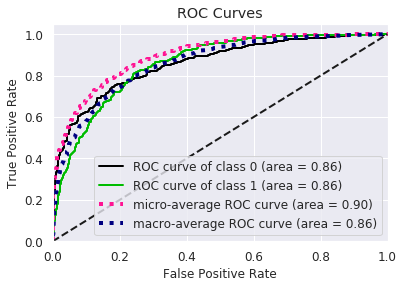

In [51]:
plot_roc(y_test, pred_benchmark_both)

**The cumulative gains chart shows the percentage of the overall number of cases in a given category "gained" by targeting a percentage of the total number of cases. For example, the orange line crosses the point (0.4, 0.8), which means if the company contacts 40% of the customer, it will get 80% of the customers who will churn. Again, the result here is satisfactory.**

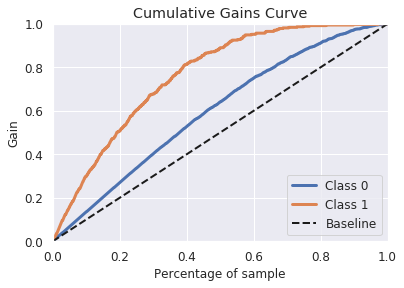

In [52]:
plot_cumulative_gain(y_test, pred_benchmark_both)

**The lift chart is derived from the cumulative gains chart; the values on the y axis correspond to the ratio of the cumulative gain for each curve to the baseline. For example, the orange line crosses the point (0.4, 2) which means if the company contacts 40% of the customer, the ratio of cumulative gain to the base line is 2. The value of baseline here is 0.4, so the cumulative gain at this point is 0.8, which is compatible to the result above.**

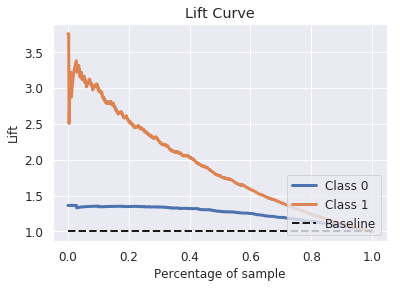

In [53]:
plot_lift_curve(y_test, pred_benchmark_both)

### 8.4 Logistic Model with Variable Transformations

In [54]:
X_train = training_data.iloc[:, : -3].join(training_data.iloc[:, -1: ]).copy()
X_test = test_data.iloc[:, : -3].join(test_data.iloc[:, -1: ]).copy()
X_train["Intercept"] = 1
X_test["Intercept"] = 1

In [55]:
logit_trans = sm.Logit( y_train, pd.get_dummies(X_train, drop_first = True) ).fit()

In [56]:
logit_trans.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
=====================================================================================
Model:                     Logit                   Pseudo R-squared:        0.286    
Dependent Variable:        Churn                   AIC:                     4699.7518
Date:                      2018-12-24 19:21        BIC:                     4858.9954
No. Observations:          5626                    Log-Likelihood:          -2325.9  
Df Model:                  23                      LL-Null:                 -3257.3  
Df Residuals:              5602                    LLR p-value:             0.0000   
Converged:                 1.0000                  Scale:                   1.0000   
No. Iterations:            7.0000                                                    
-------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------
gender                                -0.0499   0.0731 -0.6829 0.4947 -0.1932  0.0933
SeniorCitizen                          0.2683   0.0951  2.8222 0.0048  0.0820  0.4546
Partner                                0.0020   0.0873  0.0230 0.9817 -0.1690  0.1730
Dependents                            -0.1126   0.1003 -1.1231 0.2614 -0.3091  0.0839
tenure                                 0.0137   0.0065  2.1058 0.0352  0.0009  0.0264
PhoneService                          -0.0261   0.7257 -0.0360 0.9713 -1.4486  1.3963
MultipleLines                          0.5248   0.1989  2.6390 0.0083  0.1351  0.9146
OnlineSecurity                        -0.1356   0.2002 -0.6772 0.4983 -0.5280  0.2568
OnlineBackup                          -0.0133   0.1964 -0.0676 0.9461 -0.3982  0.3716
DeviceProtection                       0.1140   0.1972  0.5781 0.5632 -0.2725  0.5005
TechSupport                           -0.0412   0.2025 -0.2033 0.8389 -0.4380  0.3557
StreamingTV                            0.5771   0.3666  1.5743 0.1154 -0.1414  1.2956
StreamingMovies                        0.4915   0.3653  1.3454 0.1785 -0.2245  1.2075
PaperlessBilling                       0.3664   0.0841  4.3556 0.0000  0.2015  0.5312
MonthlyCharges                        -0.0090   0.0355 -0.2531 0.8002 -0.0785  0.0605
cbrt_TotalCharges                     -0.2717   0.0343 -7.9300 0.0000 -0.3388 -0.2045
Intercept                              0.9753   0.9052  1.0774 0.2813 -0.7989  2.7495
InternetService_Fiber optic            1.4798   0.8916  1.6598 0.0970 -0.2676  3.2272
InternetService_No                    -1.4055   0.9018 -1.5586 0.1191 -3.1730  0.3620
Contract_One year                     -0.7089   0.1203 -5.8920 0.0000 -0.9447 -0.4731
Contract_Two year                     -1.6122   0.1966 -8.1994 0.0000 -1.9976 -1.2268
PaymentMethod_Credit card (automatic)  0.0124   0.1274  0.0977 0.9222 -0.2373  0.2622
PaymentMethod_Electronic check         0.2800   0.1076  2.6029 0.0092  0.0691  0.4908
PaymentMethod_Mailed check            -0.0193   0.1294 -0.1491 0.8815 -0.2730  0.2344
=====================================================================================

"""

In [57]:
pred_trans = logit_trans.predict( pd.get_dummies(X_test, drop_first = True ) )
pred_trans_both = np.array([ 1 - pred_trans, pred_trans ]).T

**Everything is as good as before.**

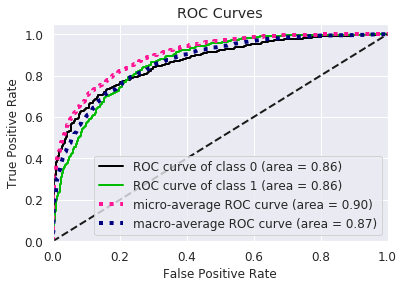

In [58]:
plot_roc(y_test, pred_trans_both)

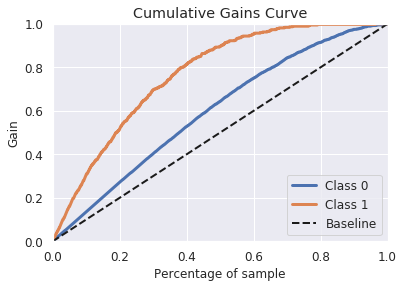

In [59]:
plot_cumulative_gain(y_test, pred_trans_both)

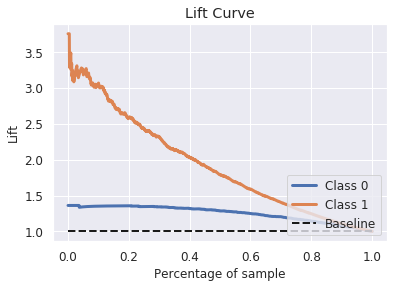

In [60]:
plot_lift_curve(y_test, pred_trans_both)

### 8.5 Logistic Model with Variable Transformations and Variable Selections

Here we apply Backward Stepwise Selection Method.

In [61]:
X2_train = pd.get_dummies(X_train, drop_first = True)
res_select = pd.DataFrame(columns = X2_train.columns)

# Apply Backward Setpwise Selection Method:
for i in range(X2_train.shape[1]):
    logit = LogisticRegression(fit_intercept = False)
    rfe = RFE(logit, n_features_to_select = i + 1)
    logit_fit = rfe.fit(X2_train, y_train)
    res_select = res_select.append(pd.DataFrame(logit_fit.get_support(), columns = [i + 1], index = X2_train.columns).T)

In [62]:
# Unite Dummy Again.
res_select["InternetService"] = res_select["InternetService_Fiber optic"] | res_select["InternetService_No"]
res_select["Contract"] = res_select["Contract_One year"] | res_select["Contract_Two year"]
res_select["PaymentMethod"] = res_select["PaymentMethod_Credit card (automatic)"] | res_select["PaymentMethod_Electronic check"] | res_select["PaymentMethod_Mailed check"]
res_select.drop( ["InternetService_Fiber optic",
                  "InternetService_No", 
                  "Contract_One year", 
                  "Contract_Two year", 
                  "PaymentMethod_Credit card (automatic)", 
                  "PaymentMethod_Electronic check", 
                  "PaymentMethod_Mailed check"], axis = 1, inplace = True)
res_select["Intercept"] = True

In [63]:
# Fetch the model with the lowest BIC.
aic_bic = pd.DataFrame(columns = ["AIC", "BIC"])

text_trap = io.StringIO()
sys.stdout = text_trap

for row in res_select.index:
    logit = sm.Logit(y_train, pd.get_dummies(X_train.loc[:, res_select.loc[row]], drop_first = True)).fit()
    aic_bic = aic_bic.append( pd.Series({"AIC": logit.aic, "BIC": logit.bic}, name = row) )
    
sys.stdout = sys.__stdout__

**The best model:**

In [64]:
res_select.iloc[ [aic_bic["BIC"].argmin()], np.where( res_select.loc[ [aic_bic["BIC"].argmin()] ] )[1] ]

,SeniorCitizen,PhoneService,MultipleLines,StreamingTV,StreamingMovies,PaperlessBilling,cbrt_TotalCharges,Intercept,InternetService,Contract,PaymentMethod
14,True,True,True,True,True,True,True,True,True,True,True


**We see that the BIC of this model is the lowest among the three.**

In [65]:
logit = sm.Logit( y_train, pd.get_dummies(X_train.loc[:, res_select.loc[ aic_bic["BIC"].argmin() ] ], drop_first = True ) ).fit()
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Logit
======================================================================================
Model:                      Logit                   Pseudo R-squared:        0.284    
Dependent Variable:         Churn                   AIC:                     4695.2841
Date:                       2018-12-24 19:21        BIC:                     4794.8114
No. Observations:           5626                    Log-Likelihood:          -2332.6  
Df Model:                   14                      LL-Null:                 -3257.3  
Df Residuals:               5611                    LLR p-value:             0.0000   
Converged:                  1.0000                  Scale:                   1.0000   
No. Iterations:             7.0000                                                    
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------
SeniorCitizen                          0.3142   0.0929   3.3823 0.0007  0.1321  0.4962
PhoneService                          -0.3041   0.1398  -2.1755 0.0296 -0.5780 -0.0301
MultipleLines                          0.4715   0.0906   5.2025 0.0000  0.2939  0.6491
StreamingTV                            0.4613   0.0910   5.0710 0.0000  0.2830  0.6396
StreamingMovies                        0.3799   0.0906   4.1927 0.0000  0.2023  0.5574
PaperlessBilling                       0.3768   0.0836   4.5083 0.0000  0.2130  0.5407
cbrt_TotalCharges                     -0.2160   0.0124 -17.4386 0.0000 -0.2403 -0.1918
Intercept                              0.4550   0.1779   2.5572 0.0106  0.1062  0.8037
InternetService_Fiber optic            1.2421   0.1043  11.9126 0.0000  1.0378  1.4465
InternetService_No                    -0.9697   0.1465  -6.6190 0.0000 -1.2568 -0.6825
Contract_One year                     -0.6906   0.1168  -5.9153 0.0000 -0.9195 -0.4618
Contract_Two year                     -1.5354   0.1795  -8.5548 0.0000 -1.8871 -1.1836
PaymentMethod_Credit card (automatic)  0.0101   0.1274   0.0795 0.9367 -0.2396  0.2599
PaymentMethod_Electronic check         0.2936   0.1073   2.7358 0.0062  0.0833  0.5039
PaymentMethod_Mailed check            -0.0350   0.1286  -0.2721 0.7855 -0.2871  0.2171
======================================================================================

"""

**After variable selections, the multicollinearity problem is alleviated. We meet another assumption!**

Text(0.5, 1.0, 'Correlation Matrix after Variable Selection')

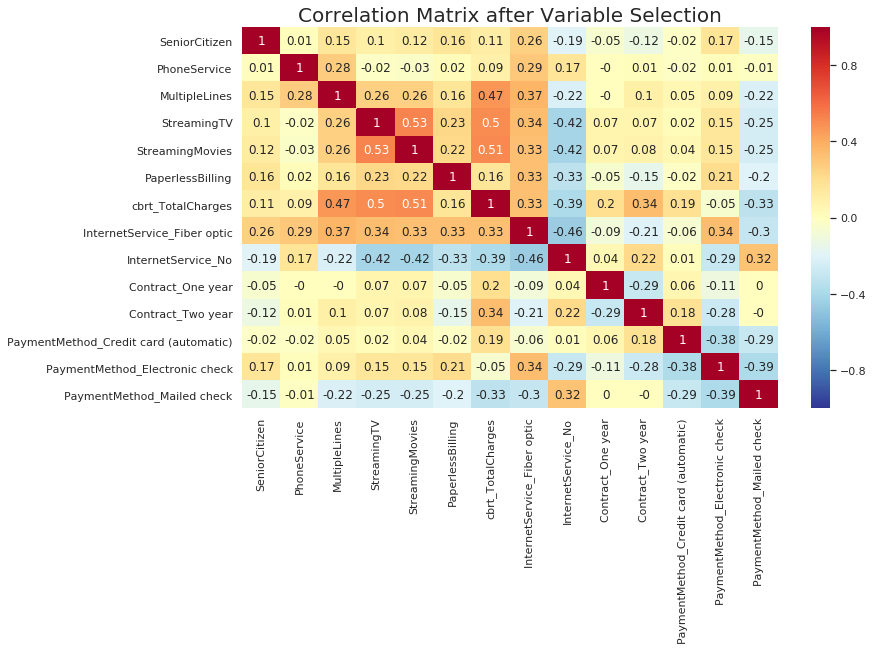

In [66]:
sns.set(font_scale = 1)
plt.figure(figsize = (12, 7))
ax = plt.axes()
sns.heatmap(pd.get_dummies(X_train.loc[:, res_select.loc[ aic_bic["BIC"].argmin() ] ].drop(["Intercept"], axis = 1), drop_first = True).corr().round(2), cmap = "RdYlBu_r", vmin = -1, vmax = 1, annot = True)
ax.set_title("Correlation Matrix after Variable Selection", {'fontsize': 20})

In [67]:
pred = logit.predict( pd.get_dummies(X_test.loc[:, res_select.loc[ aic_bic["BIC"].argmin() ] ], drop_first = True ) )
pred_both = np.array([ 1 - pred, pred ]).T

**Good as always.**

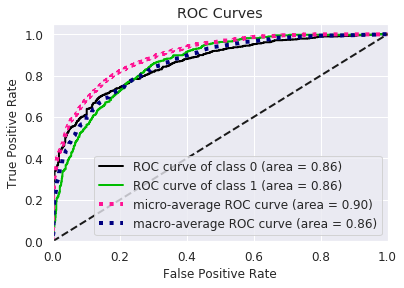

In [68]:
plot_roc(y_test, pred_both)

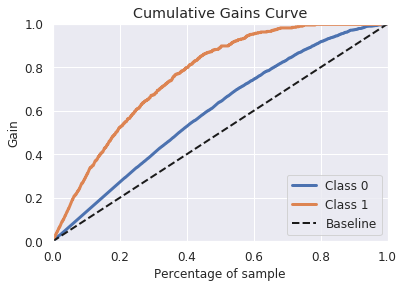

In [69]:
plot_cumulative_gain(y_test, pred_both)

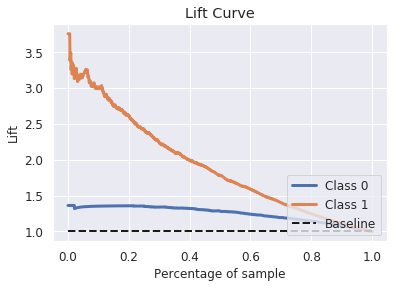

In [70]:
plot_lift_curve(y_test, pred_both)

# 9. Comparisons of the Three Models

### 9.1 Retention Profit VS Cutoff

**We have seen ROC, gain and lift plots of the three models. Clearly, they are hard to differentiate. Therefore, we need to plot the profit versus cutoff, which is directly related to the final objective.**

In [71]:
churn_rate = y_train["Churn"].mean()  # Models are not supposed to see any part of the test data.
churn_rate

0.2657305367934589

In [72]:
N_DIVISION = 1000
cutoffs = np.linspace(0, 1, N_DIVISION)

profit_benchmark = np.zeros(N_DIVISION)

for idx, cutoff in enumerate(cutoffs):
    conf_mat = confusion_matrix(y_test, pred_benchmark > cutoff)
    TP = conf_mat[1, 1]
    FP = conf_mat[0, 1]
    profit_benchmark[idx] = 25 * TP * .25 - 5 * (TP + FP) 

profit_trans = np.zeros(N_DIVISION)

for idx, cutoff in enumerate(cutoffs):
    conf_mat = confusion_matrix(y_test, pred_trans > cutoff)
    TP = conf_mat[1, 1]
    FP = conf_mat[0, 1]
    profit_trans[idx] = 25 * TP * .25 - 5 * (TP + FP) 
    
profit = np.zeros(N_DIVISION)

for idx, cutoff in enumerate(cutoffs):
    conf_mat = confusion_matrix(y_test, pred > cutoff)
    TP = conf_mat[1, 1]
    FP = conf_mat[0, 1]
    profit[idx] = 25 * TP * .25 - 5 * (TP + FP) 

**The lowest cutoff rate when retention profit hits zero doesn't indicate the best model because we have not taken into account the difference in model prediction power. However, if the company wants to maximize the retention profit, here both the non-benchmark models are potential alternatives.**

In [73]:
assert profit.max() == profit_trans.max()

[(0, 40), Text(0, 0.5, 'Retention Profit'), (0.6, 1), Text(0.5, 0, 'cutoff')]

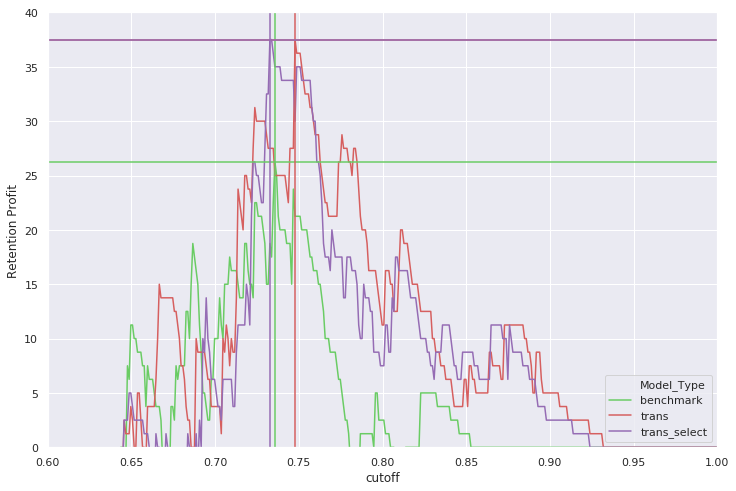

In [74]:
_ = pd.DataFrame( { "res": np.concatenate([profit_benchmark, profit_trans, profit]), "cut": np.tile(cutoffs, 3), "Model_Type": np.repeat(["benchmark", "trans", "trans_select"], N_DIVISION) })

plt.subplots(figsize=(12, 8))
g = sns.lineplot(x = "cut", y = "res", hue = "Model_Type", data = _, palette = sns.color_palette("muted")[2:5])
g.axhline(profit_benchmark.max(), color = sns.color_palette("muted")[2])
g.axvline(cutoffs[profit_benchmark.argmax()], color = sns.color_palette("muted")[2])
g.axhline(profit_trans.max(), color = sns.color_palette("muted")[3])
g.axvline(cutoffs[profit_trans.argmax()], color = sns.color_palette("muted")[3])
g.axhline(profit.max(), color = sns.color_palette("muted")[4])
g.axvline(cutoffs[profit.argmax()], color = sns.color_palette("muted")[4])
g.set(xlim = (.6, 1), ylim = (0, 40), xlabel = "cutoff", ylabel = "Retention Profit")

### 9.2 The Optimal Model for Performance

**From the test sample, we see that under the assumption of Break-Even Budget, logistic regression with variable transformations can acquire the biggest number of customers who will churn, which is 130!**

* BRONZE: Benchmark Logistic Regression

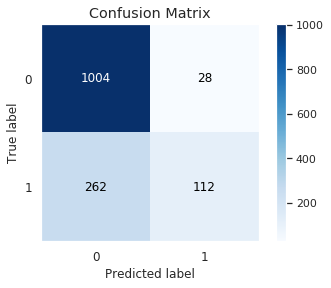

In [75]:
plot_confusion_matrix(y_test, pred_benchmark > cutoffs[np.where(profit_benchmark >= 0)[0].min()])

* GOLD: Logistic Regression with Vairable Transformations

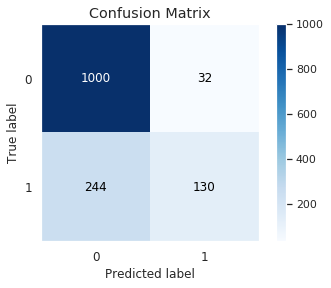

In [76]:
plot_confusion_matrix(y_test, pred_trans > cutoffs[np.where(profit_trans >= 0)[0].min()])

* SILVER: Logistic Regression with Variable Transformations and Selections

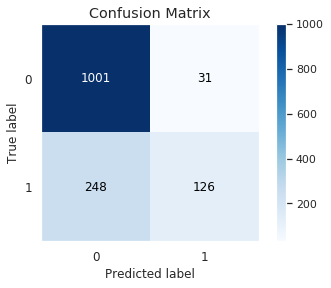

In [77]:
plot_confusion_matrix(y_test, pred > cutoffs[np.where(profit >= 0)[0].min()])

### 9.3 Cutoff Selection and Economical Parameters

**Now we need to go back to the original sample. Suppose our test set is as large as the orignal sample, what will be the case?**

**Cutoff:**

In [78]:
cutoff = cutoffs[np.where(profit_trans >= 0)[0].min()]
cutoff

0.6456456456456456

**Number of Customers to Call in the Original Sample:**  
If the Telco Sector is to contact a new group of customers as large as the original sample size (after dropping 11 missings), this is the target size (in term of number of customers) to contact
through the Retention Commercial Campaign in order to have a Break-even Balance.

In [79]:
conf_mat = confusion_matrix(y_test, pred_trans > cutoff)
num_customer_to_call = (conf_mat.sum(axis = 0)[1]) / test_data.shape[0] * reg_data.shape[0]
num_customer_to_call

810.230440967283

**Churn Rate:**

In [80]:
churn_rate_origin = reg_data["Churn"].mean()
churn_rate_origin

0.26578498293515357

**Rate of Successful Retention:**

In [81]:
rate_of_success_reten = conf_mat[1, 1] / conf_mat.sum(axis = 0)[1] / 4
rate_of_success_reten 

0.2006172839506173

**Expected Number of Customers Retained through Campaign:**

In [82]:
num_customer_retained = num_customer_to_call * rate_of_success_reten
num_customer_retained 

162.54623044096726

# 10. Conclusions

1. We use the benchmark logistic model (model with all original variables) to get the insight of customer churns, from which we conclude:  
1) Signing long-term contracts is the best strategy.  
2) Special attention needs to be paid to new customers (who churns easily) to transform convert them into long tenured customers (who rarely churns).  
3) Customers with multiple lines may care more about service and leave easily.  
4) Senior customers churns easily, probably due to their higher sensitivity to price.  
5) The feasibility of pricing strategy requires further analysis.  

2. We apply the logistic model with variable transformations and variable selections to business simulation to get the best predictive performance, from which we conclude:  
 1) The cutoff rate is about 0.646, which means if a customer's predicted churn probability is higher than this value, she/he needs to be contacted.  
 2) The number of customers to call in the origin sample (of which the size is 7032 observations after dropping 11 missing values) is about 810.  
 3) The churn rate is about 0.266.  
 4) The expected number of customers retained through this campaign is about 163.  
 5) The rate of successful retention (customers retained / customers contacted) contacted is 0.2.
 

# 11. Limitations

1. We confine ourselves to logistic regression models as required by the project guideline, while there may be other supervised learning models which provide better predictions.
2. We assume each retained customer generate the same revenue, which is usually not true as we have shown in previous exploratory data analysis: Very few customers generate extremely high revenue, who are called Most Valuable Customers and require higher attention.

# 12. References

* Songul Albayrak: Customer churn prediction in telecommunication
* Clement Kirui, Li Hong, Wilson Cheruiyot, Hillary Kirui: Predicting Customer Churn in Mobile Telephony Industry Using Probabilistic Classifiers in Data Mining, *International Journal of Computer Science Issues*
* Wikipedia: Sensitivity and specificity https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* Statistics Solutions: Assumptions of Logistic Regression https://www.statisticssolutions.com/assumptions-of-logistic-regression/
* IBM Knowledge Center: Cumulative Gains and Lift Charts https://www.ibm.com/support/knowledgecenter/en/SSLVMB_23.0.0/spss/tutorials/mlp_bankloan_outputtype_02.html
